# Hyperparamètres - Variation du nombre d'époques

## Objectif
La démarche de recherche avec variation du nombre d'époques doit nous permettre de déterminer leur nombre optimal.

## Hypothèses
Les hypothèses sont les suivantes :

- Le nombre d'époques optimal est celui qui permet d'obtenir le meilleur score de validation.
- Un nombre d'époques trop faible ne permet pas au modèle d'apprendre suffisamment.
- Un nombre d'époques trop élevé peut conduire à un surapprentissage.

## Étapes de la démarche

- Intégrer l'objet GridSearchCV de Scikit-Learn.
- Définir les nombres d'époques à tester. (5, 10, 20)
- Récupérer les métriques de validation pour chaque nombre d'époques.
- Comparer les métriques de validation pour chaque nombre d'époques.
- Déterminer le nombre d'époques optimal.

## Conclusion

En conclusion, dans le cadre de nos recherches, avec nos données et notre modèle, le nombre d'époques optimal parmi ceux essayés est 10, car il permet d'obtenir le meilleur score de validation.

Afin d'affiner ce résultat, une recherche plus précise du nombre optimal sera menée en se basant sur ces résultats.

**Par rapport à la complexité de l'entrainement, les différents nombres d'époques seront comparés en utilisant des images de dimension 64x64**

In [ ]:
# Check that GPU is used
import tensorflow as tf
from keras import backend as K
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

tf.compat.v1.reset_default_graph()
K.clear_session()
tf.config.list_physical_devices('GPU')


In [64]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 64, 64 # Function to load and resize images from a folder

In [65]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [66]:
# Generate augmented for the training set
from data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 2954 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 2954
Augmented PNEUMONIA count: 5000


In [67]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

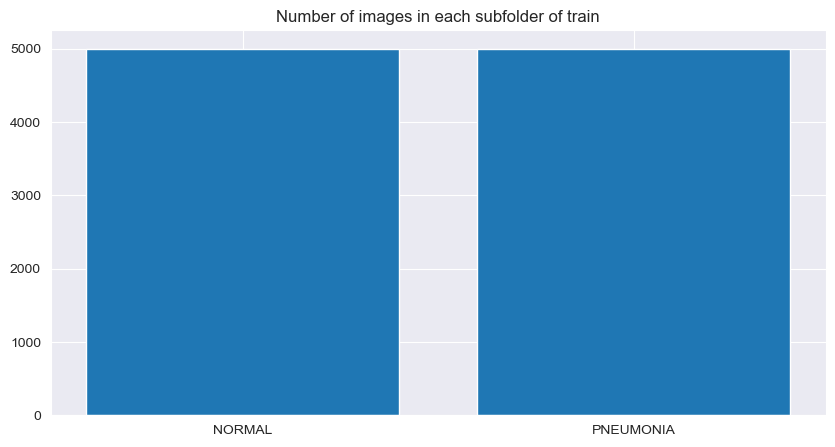

In [68]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

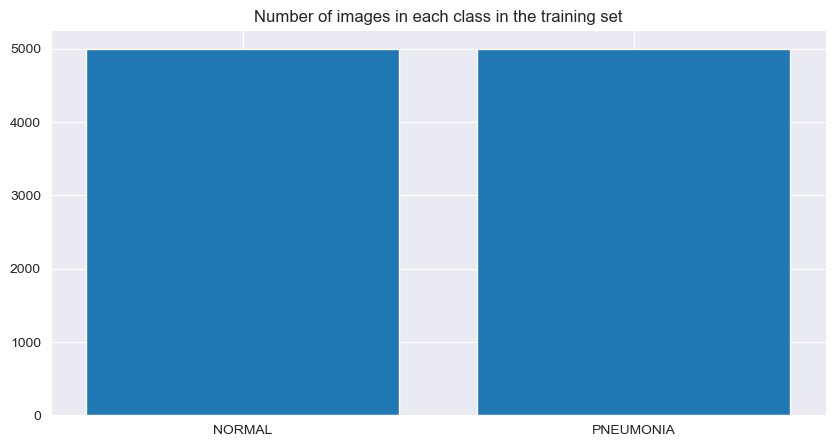

In [69]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [70]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(64, 64, 1)


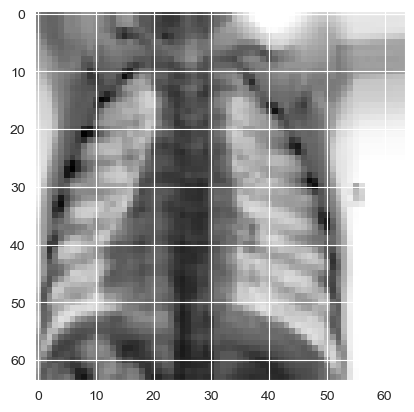

In [71]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [72]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [73]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [74]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [75]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the number of folds for cross-validation
n_splits = 5
epochs = [5, 10, 20]

# Wrap your create_model function with KerasClassifier
wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the range of epochs
param_grid = {
    'epochs': epochs,
}

datagen = ImageDataGenerator()

# Initialize the GridSearchCV object with your wrapped_model, param_grid, and the desired number of folds
grid_search = GridSearchCV(estimator=wrapped_model, param_grid=param_grid, cv=n_splits, return_train_score=True)

# Combine X_train and X_val to use the whole dataset for GridSearchCV
X_combined = np.concatenate([X_train, X_val])
y_combined = np.concatenate([y_train, y_val])

# Fit the GridSearchCV object to your training data
grid_result = grid_search.fit(X_combined, y_combined, callbacks=[early_stop])

# Get the best number of epochs and the corresponding score
best_epochs = grid_result.best_params_['epochs']
best_score = grid_result.best_score_
# Summarize the results

print('Best : {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{},{} with: {}'.format(mean, stdev, param))


C:\Users\proma\AppData\Local\Temp\ipykernel_10228\1449484450.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  wrapped_model = KerasClassifier(build_fn=create_model, verbose=1)


Epoch 1/5
251/251 [==============================] - 3s 8ms/step - loss: 0.4856 - accuracy: 0.7582 - auc: 0.8309
Epoch 2/5
251/251 [==============================] - 2s 7ms/step - loss: 0.3368 - accuracy: 0.8637 - auc: 0.9240
Epoch 3/5
251/251 [==============================] - 2s 7ms/step - loss: 0.2723 - accuracy: 0.8903 - auc: 0.9514
Epoch 4/5
251/251 [==============================] - 2s 7ms/step - loss: 0.2189 - accuracy: 0.9130 - auc: 0.9681
Epoch 5/5
251/251 [==============================] - 1s 3ms/step - loss: 0.1926 - accuracy: 0.9284 - auc: 0.9830
Epoch 1/5
251/251 [==============================] - 2s 7ms/step - loss: 0.4927 - accuracy: 0.7500 - auc: 0.9217
Epoch 2/5
251/251 [==============================] - 2s 7ms/step - loss: 0.3095 - accuracy: 0.8726 - auc: 0.9367
Epoch 3/5
251/251 [==============================] - 2s 7ms/step - loss: 0.2679 - accuracy: 0.8897 - auc: 0.9529
Epoch 4/5
251/251 [==============================] - 2s 7ms/step - loss: 0.2111 - accuracy: 0.91

In [76]:
# Get accuracy scores for each fold (train and validation)
# Initialize lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []

# Get the number of combinations tried during the grid search
n_combinations = len(grid_result.cv_results_['params'])

# Iterate over each combination tried during the grid search
for i in range(n_combinations):
    # Initialize empty lists for loss, accuracy, val_loss, and val_accuracy for this combination
    loss = []
    acc = []
    val_loss = []  # Note: GridSearchCV does not return loss or val_loss
    val_acc = []

    # Iterate through each fold and get the scores for this combination
    for fold in range(n_splits):
        acc.append(grid_result.cv_results_[f'split{fold}_train_score'][i])
        val_acc.append(grid_result.cv_results_[f'split{fold}_test_score'][i])

    # Calculate the mean scores for this combination
    loss_mean = np.nan  # GridSearchCV does not return loss
    acc_mean = np.mean(acc)
    val_loss_mean = np.nan  # GridSearchCV does not return val_loss
    val_acc_mean = np.mean(val_acc)

    # Append the mean scores to the histories list
    history = {
        "loss": loss_mean,
        "accuracy": acc_mean,
        "val_loss": val_loss_mean,
        "val_accuracy": val_acc_mean,
    }
    histories.append(history)

# Calculate mean accuracy scores across all folds for each combination
loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return loss
acc = [np.mean(history["accuracy"]) for history in histories]
val_loss = [np.nan for _ in range(n_combinations)]  # GridSearchCV does not return val_loss
val_acc = [np.mean(history["val_accuracy"]) for history in histories]

print("Loss for each combination: ", loss)
print("Accuracy for each combination: ", acc)
print("Validation loss for each combination: ", val_loss)
print("Validation accuracy for each combination: ", val_acc)

Loss for each combination:  [nan, nan, nan]
Accuracy for each combination:  [0.9523007273674011, 0.9723687648773194, 0.9937350273132324]
Validation loss for each combination:  [nan, nan, nan]
Validation accuracy for each combination:  [0.9294102191925049, 0.9301089882850647, 0.9251182079315186]


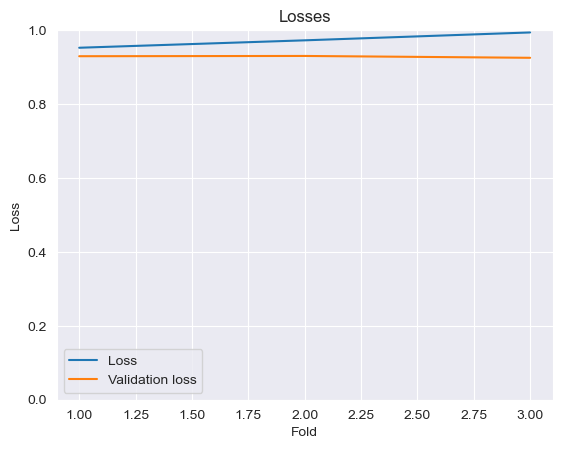

In [77]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

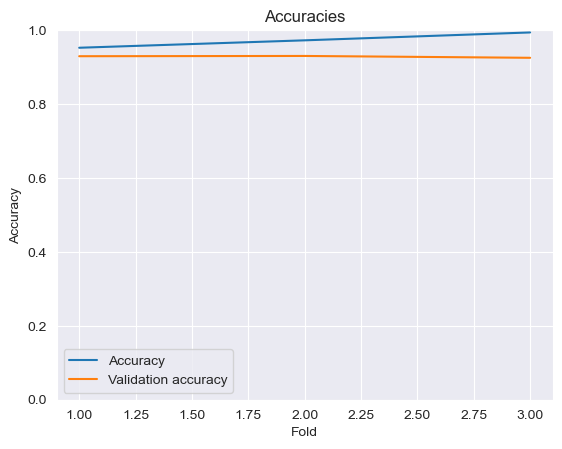

In [78]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [79]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=100)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=100)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs[0], verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/5
100/100 [==============================] - 3s 19ms/step - loss: 0.5249 - accuracy: 0.7203 - auc: 0.9385 - val_loss: 0.6955 - val_accuracy: 0.7500 - val_auc: 0.7500
Epoch 2/5
100/100 [==============================] - 2s 16ms/step - loss: 0.3118 - accuracy: 0.8731 - auc: 0.9376 - val_loss: 0.6728 - val_accuracy: 0.7500 - val_auc: 0.8125
Epoch 3/5
100/100 [==============================] - 2s 16ms/step - loss: 0.2437 - accuracy: 0.9051 - auc: 0.9613 - val_loss: 0.8684 - val_accuracy: 0.6875 - val_auc: 0.7891
Epoch 4/5
100/100 [==============================] - 2s 16ms/step - loss: 0.2023 - accuracy: 0.9246 - auc: 0.9736 - val_loss: 0.5641 - val_accuracy: 0.7500 - val_auc: 0.8828
Epoch 5/5
100/100 [==============================] - 2s 16ms/step - loss: 0.1805 - accuracy: 0.9333 - auc: 0.9789 - val_loss: 0.6886 - val_accuracy: 0.6875 - val_auc: 0.9375


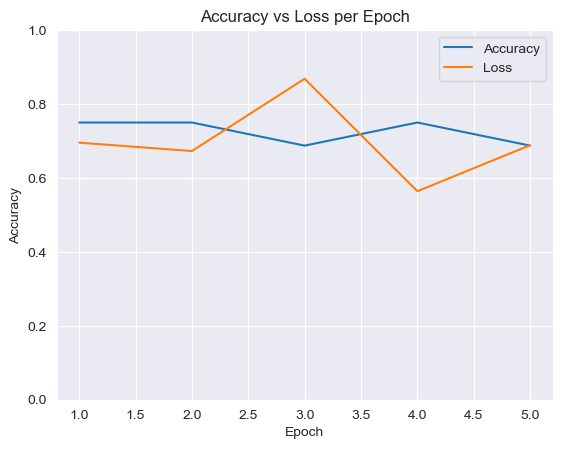

In [80]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [81]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 2ms/step


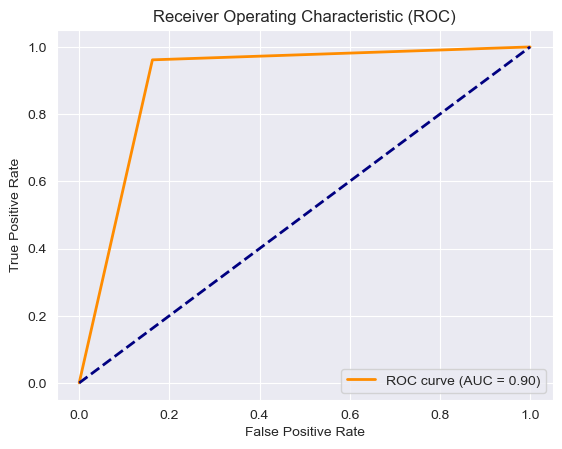

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [83]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[196  38]
 [ 15 375]]


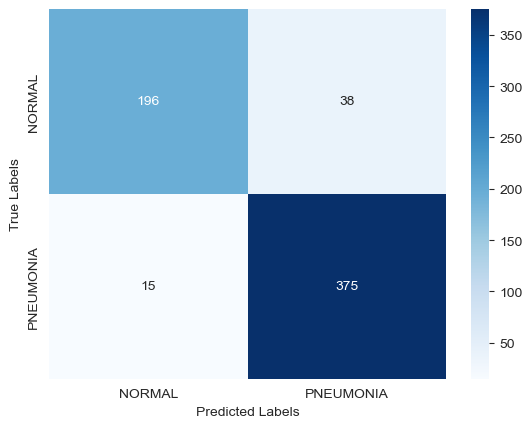

In [84]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [85]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.93      0.84      0.88       234
   PNEUMONIA       0.91      0.96      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



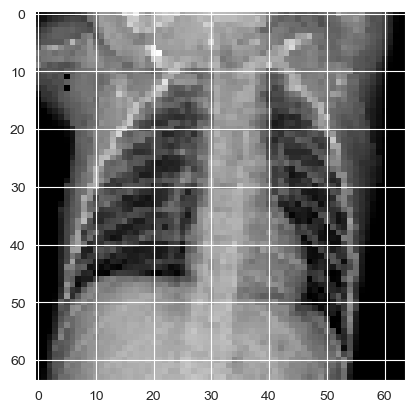

C:\Users\proma\AppData\Roaming\Python\Python39\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


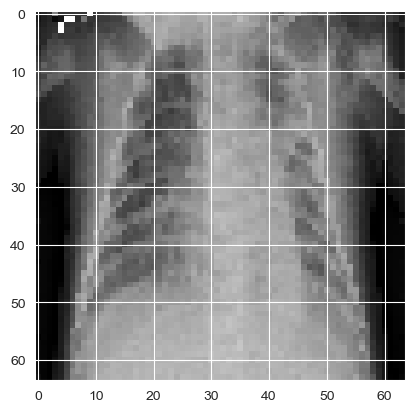

In [86]:
# Heatmaps and Grad-CAM
from cam import get_img_array
import cv2
import matplotlib.pyplot as plt

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()

    image["array"] = get_img_array(image["path"], size=(img_width, img_height))


In [87]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [88]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 6, 6, 128)      

In [94]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_67"

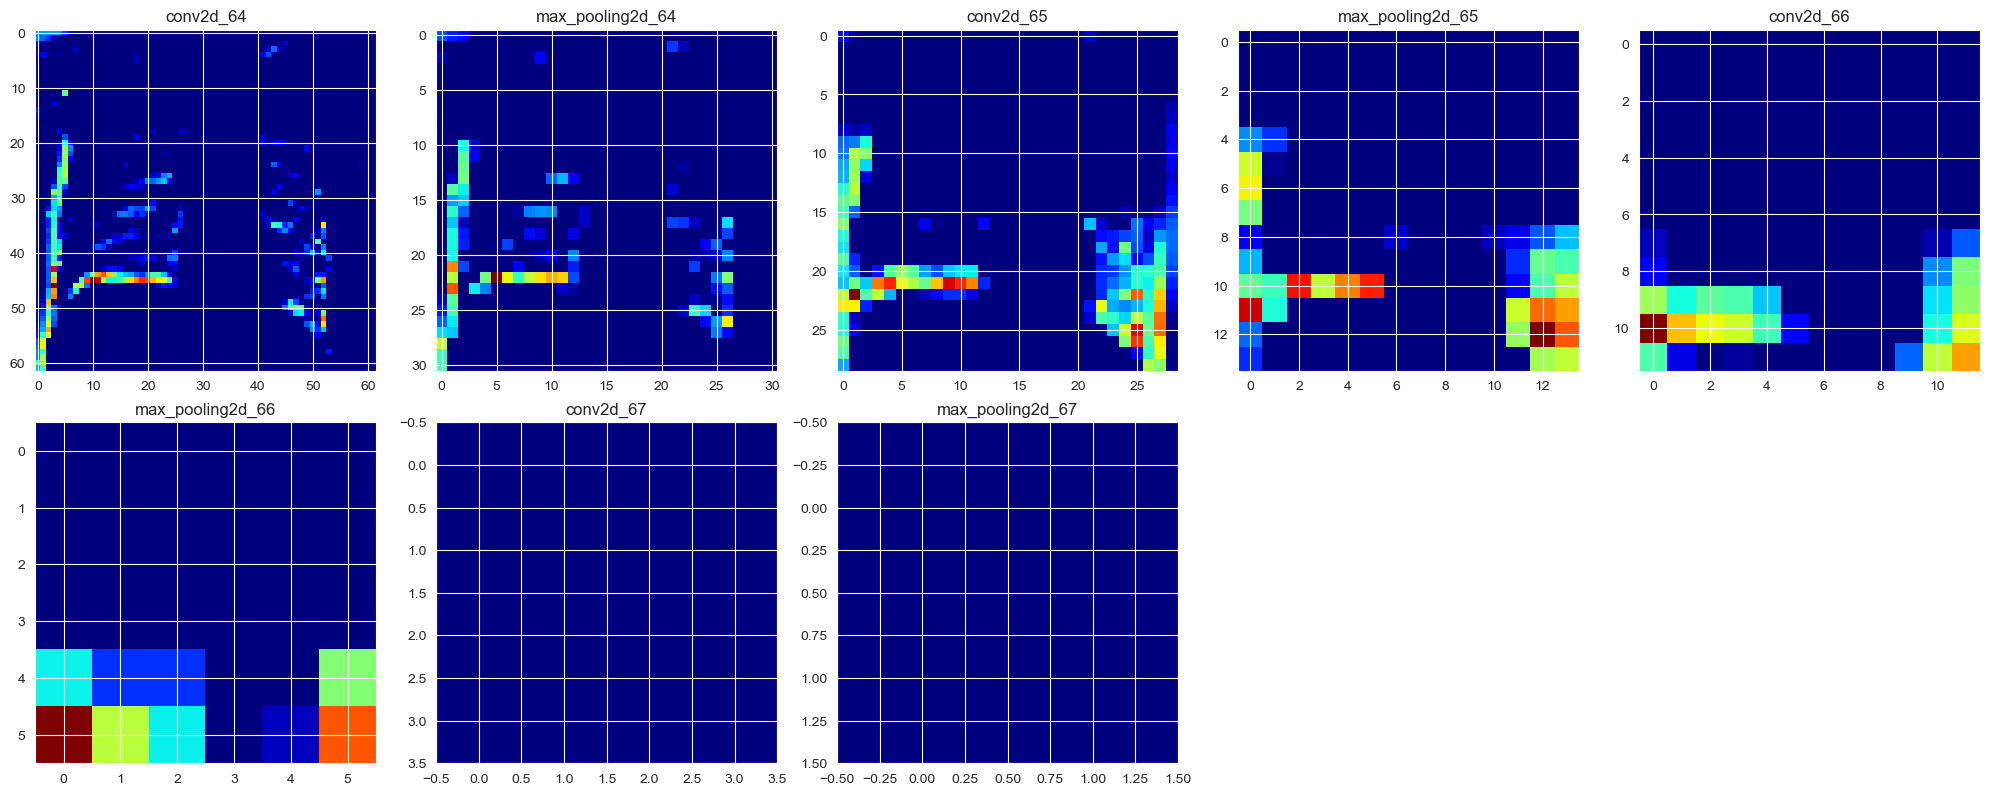

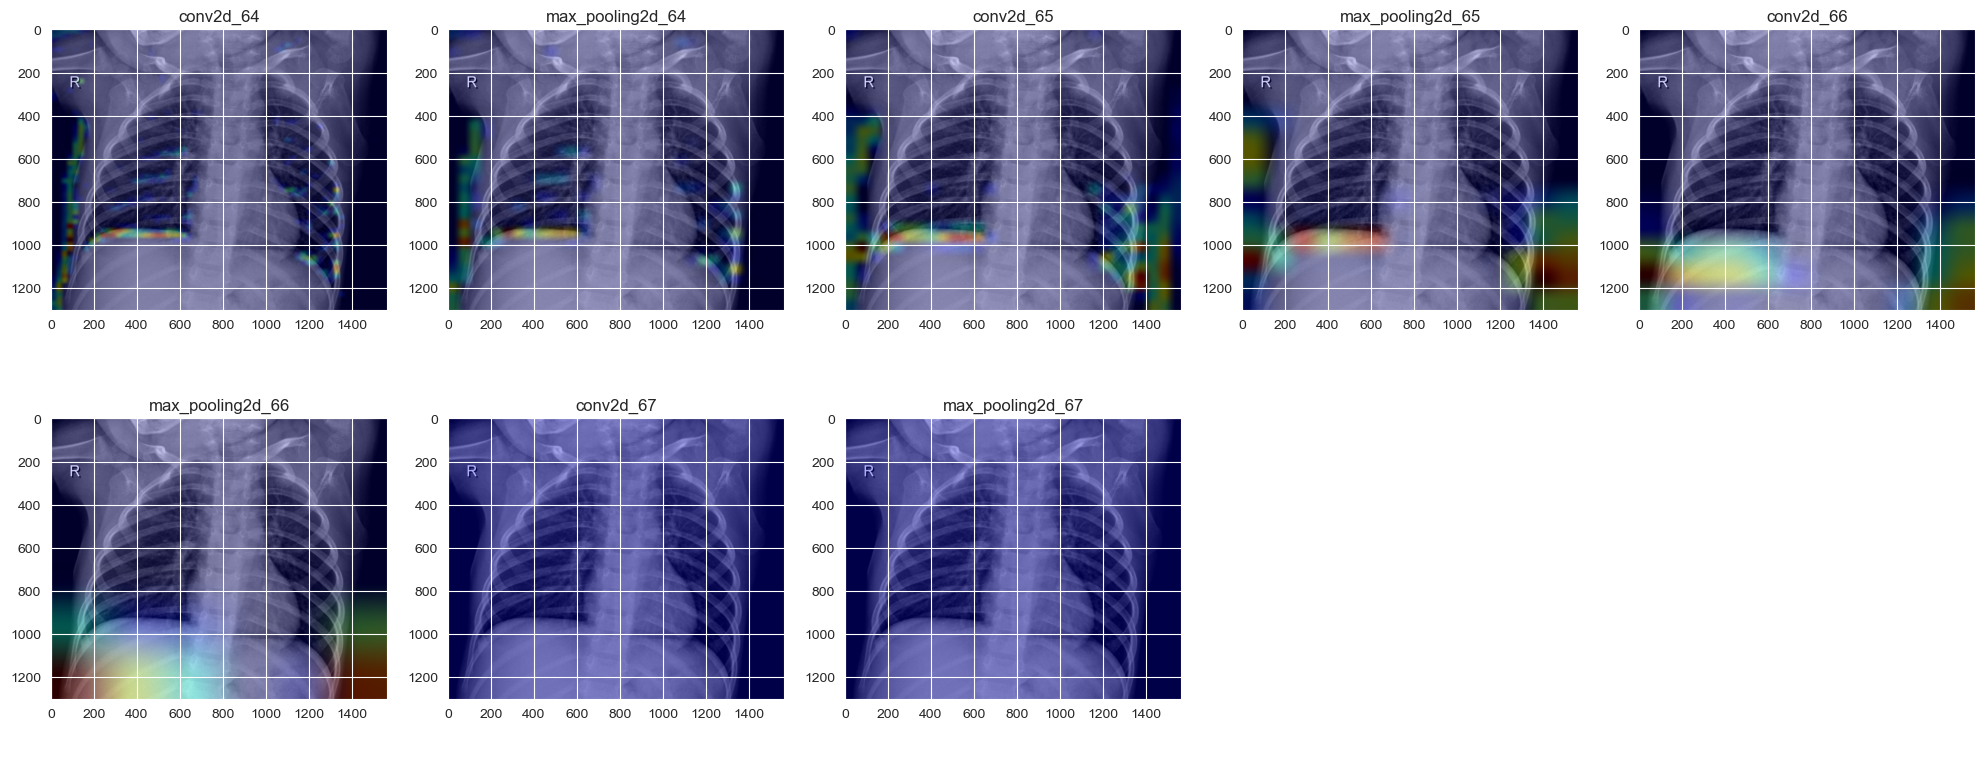

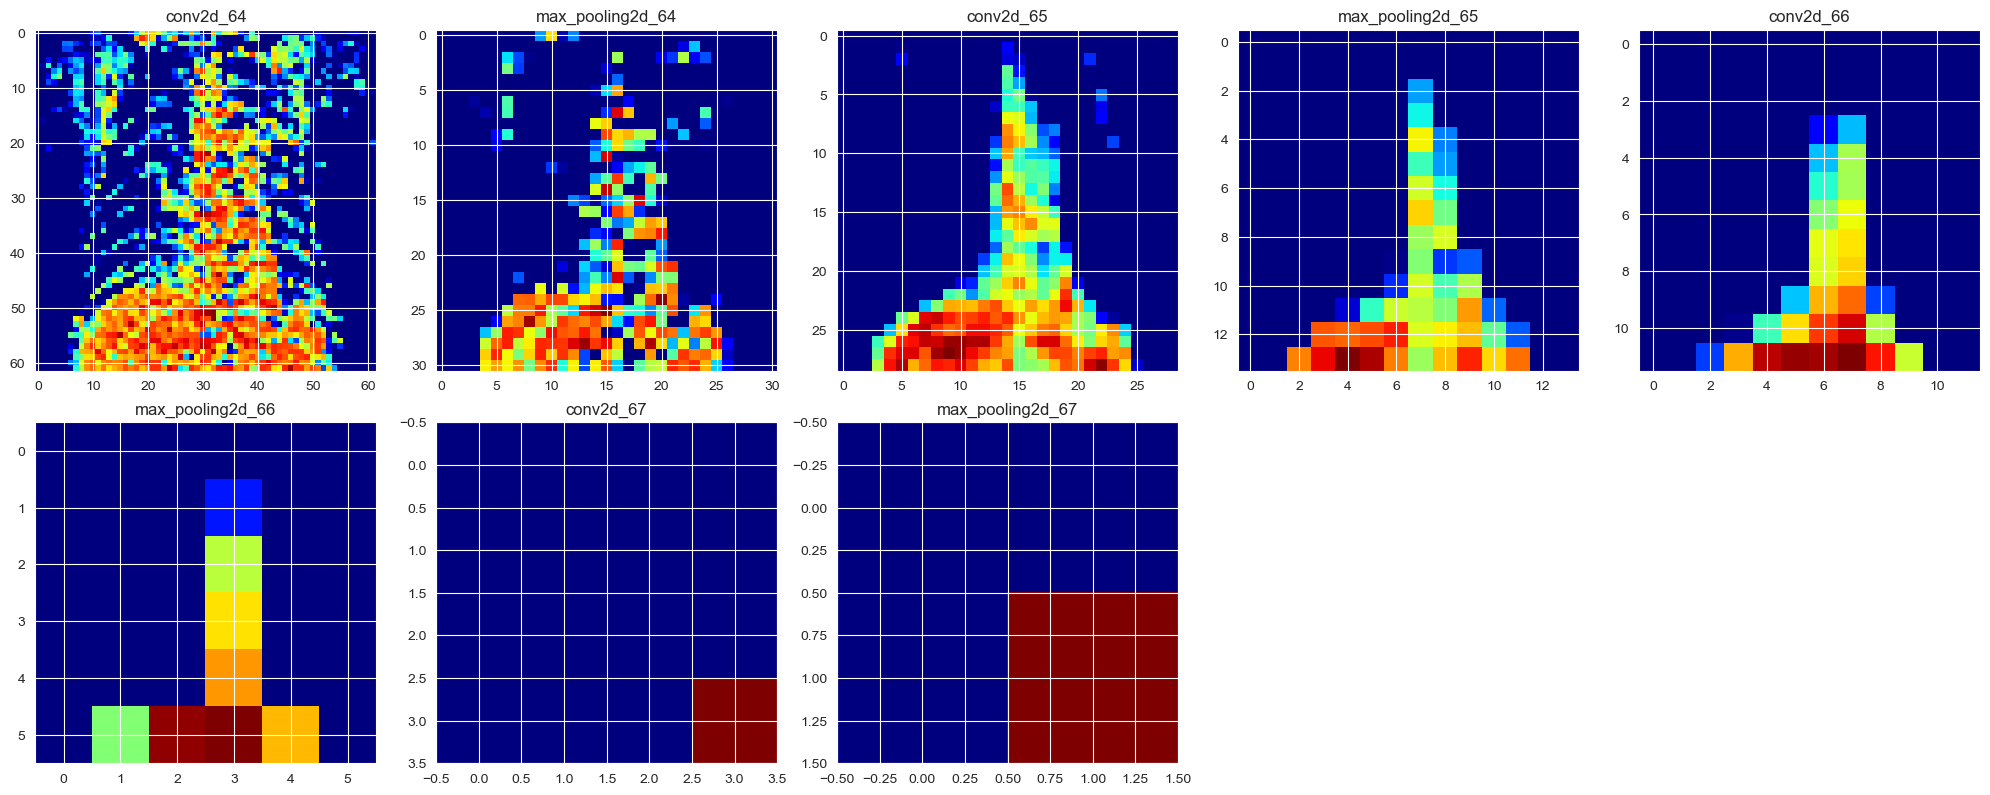

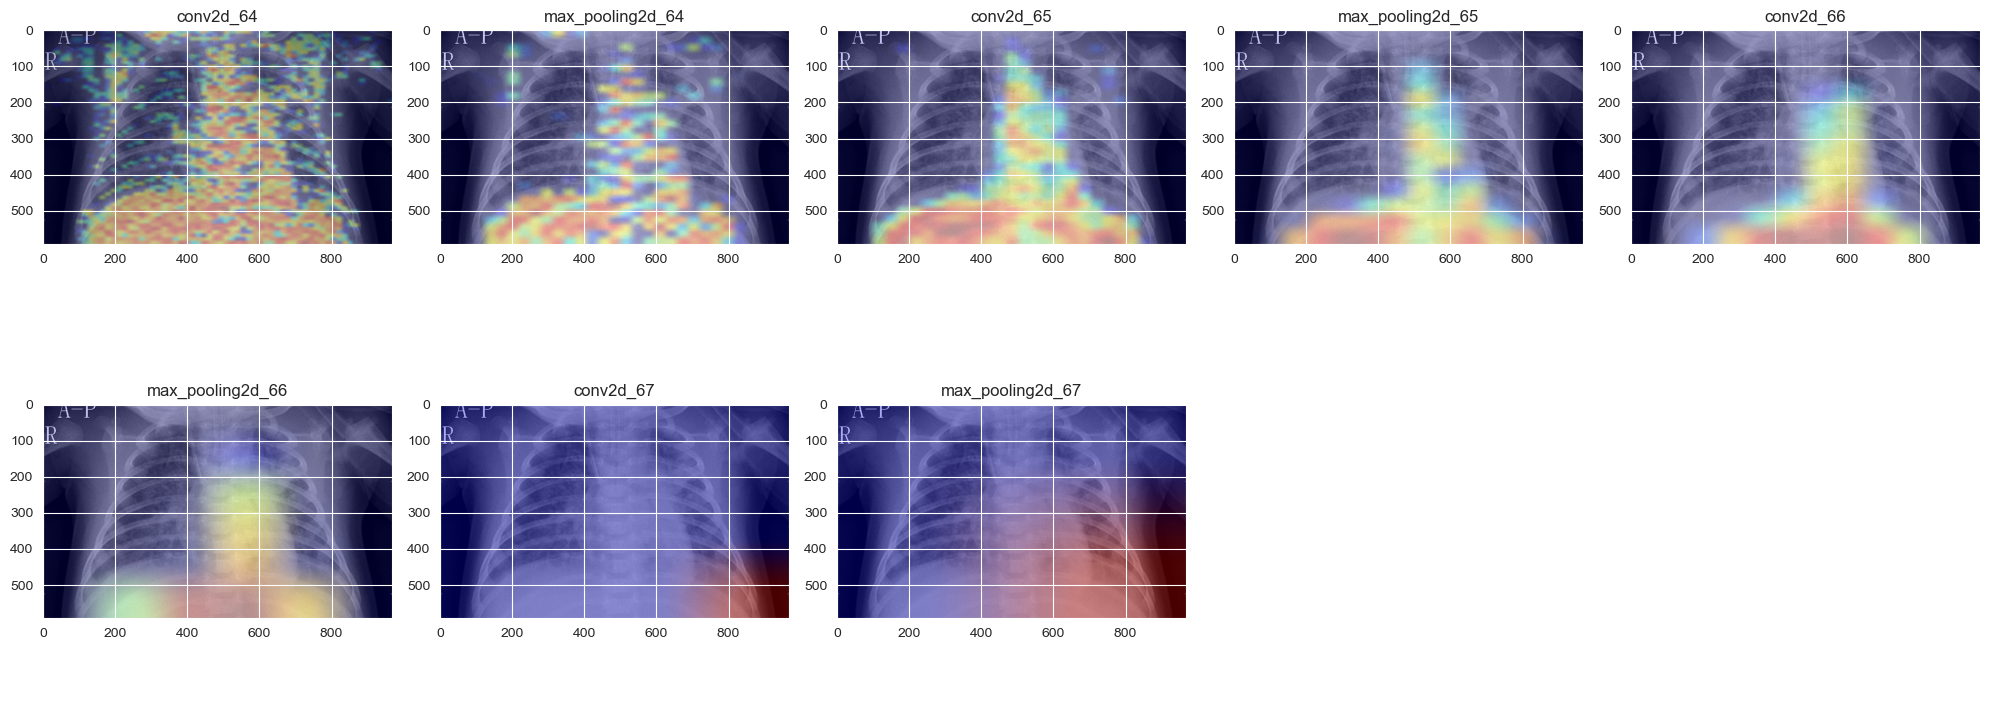

In [95]:
from cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [96]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 0s 21ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 21ms/step
[[0.]]
Predicted class: NORMAL
